In [1]:
import sys; sys.path.append("..")
import configs 

In [2]:
from models.Model_BasicNCA2D_GroupEq import BasicNCA2D_GroupEq
from models.Model_OctreeNCA_2d_patching2 import OctreeNCA2DPatch2 
from models.Model_BasicNCA2D import BasicNCA2D

## LOAD gconv2d

In [3]:
import sys; sys.path.append("..")
import external_libraries.GrouPy.groupy.gconv.pytorch_gconv as gconv

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"




import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


## Load the weights

In [5]:

study_config = {
    'experiment.name': r'peso_med',
    'experiment.description': "OctreeNCA2DSegmentation",
    'model.output_channels': 1,
}

study_config = study_config | configs.models.peso_med.peso_model_config
study_config = study_config | configs.trainers.nca.nca_trainer_config
study_config = study_config | configs.datasets.peso.peso_dataset_config
study_config = study_config | configs.tasks.segmentation.segmentation_task_config
study_config = study_config | configs.default.default_config

study_config['experiment.logging.also_eval_on_train'] = False
study_config['experiment.logging.evaluate_interval'] = study_config['trainer.n_epochs']+1
study_config['experiment.task.score'] = ["src.scores.PatchwiseDiceScore.PatchwiseDiceScore",
                                         "src.scores.PatchwiseIoUScore.PatchwiseIoUScore"]

#study_config['model.backbone_class'] = "BasicNCA2D"

model = OctreeNCA2DPatch2(study_config).to(device)
model_path = "/local/scratch/pvc_groupEq/baseline_results/Experiments/peso_med_fast_real_OctreeNCA2DSegmentation/models/epoch_2000/model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

OctreeNCA2DPatch2(
  (backbone_ncas): ModuleList(
    (0): BasicNCA2DFast(
      (fc0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (fc1): Conv2d(64, 13, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, padding_mode=reflect)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): BasicNCA2DFast(
      (fc0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (fc1): Conv2d(64, 13, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=16, padding_mode=reflect)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
)

## Continue

In [6]:
import einops, numpy as np
import torch, os, openslide
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch
import numpy as np
import openslide
import einops
import json
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils.BaselineConfigs import EXP_OctreeNCA
from src.models.Model_OctreeNCA_2d_patching2 import OctreeNCA2DPatch2
from src.datasets.Dataset_PESO import Dataset_PESO
from src.utils.ProjectConfiguration import ProjectConfiguration as pc

/gris/gris-f/homestud/achoucha/miniconda3/envs/nca_freeze/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# === Paths ===
model_path = "/local/scratch/pvc_groupEq/baseline_results/Experiments/peso_med_fast_real_OctreeNCA2DSegmentation/"
model_weights_path = os.path.join(model_path, "models/epoch_2000" "model.pth")  # ⬅️ Replace XX with your best epoch

In [8]:
with open(os.path.join(model_path, "config.json")) as f:
    config = json.load(f)

exp = EXP_OctreeNCA().createExperiment(
    config,
    detail_config={},
    dataset_class=Dataset_PESO,
    dataset_args={
        'patches_path': os.path.join(pc.FILER_BASE_PATH, config['experiment.dataset.patches_path']),
        'patch_size': config['experiment.dataset.input_size'],
        'path': os.path.join(pc.FILER_BASE_PATH, config['experiment.dataset.img_path']),
        'img_level': config['experiment.dataset.img_level']
    }
)

loading patches
Loaded configuration is missing keys: '['experiment.run_hash']'. Check if you are loading the correct experiment.
Reload State 2000
loading patches
loading patches

-------- Experiment Setup --------
{
    "experiment.name": "peso_med_fast_real",
    "experiment.description": "OctreeNCA2DSegmentation",
    "model.output_channels": 1,
    "model.channel_n": 16,
    "model.fire_rate": 0.5,
    "model.kernel_size": [
        3,
        7
    ],
    "model.hidden_size": 64,
    "model.batchnorm_track_running_stats": false,
    "model.train.patch_sizes": [
        null,
        null
    ],
    "model.train.loss_weighted_patching": false,
    "model.eval.patch_wise": false,
    "model.octree.res_and_steps": [
        [
            [
                320,
                320
            ],
            20
        ],
        [
            [
                80,
                80
            ],
            40
        ]
    ],
    "model.octree.separate_models": true,
    "model.ba

In [21]:
from src.datasets.Dataset_PESO import Dataset_PESO
from src.utils.Study import Study
from src.utils.ProjectConfiguration import ProjectConfiguration
from src.utils.BaselineConfigs import EXP_OctreeNCA
from src.datasets.Dataset_BCSS_Seg import Dataset_BCSS_Seg
from src.datasets.Dataset_AGGC import Dataset_AGGC
import octree_vis, torch, os, json, openslide, math
import einops
from src.models.Model_OctreeNCAV2 import OctreeNCAV2
import numpy as np, time
import torch.nn.functional as F
from src.utils.ProjectConfiguration import ProjectConfiguration as pc
from src.models.Model_OctreeNCA_2d_patching2 import OctreeNCA2DPatch2
import matplotlib.pyplot as plt
from src.utils.BaselineConfigs import EXP_OctreeNCA

torch.set_grad_enabled(False)
from src.models.UNetWrapper2D import UNetWrapper2D


model: OctreeNCA2DPatch2 = exp.model
assert isinstance(model, OctreeNCA2DPatch2)
model = model.eval()
model_device = torch.device("cuda:0")



def remove_names(x: torch.Tensor):
    x.names = [None] * len(x.names)
    return x

def align_tensor_to(x: torch.Tensor, target: str):
    if isinstance(target, tuple):
        target_str = ' '.join(target)
    elif isinstance(target, str): 
        if max(map(len, target.split())) != 1:
            #targets are like "BCHW"
            target_str = ' '.join(target)
        else:
            #targets are like "B C H W"
            target_str = target
            target = target.replace(" ", "")


    pattern = f"{' '.join(x.names)} -> {target_str}"
    x = remove_names(x)
    x = einops.rearrange(x, pattern)
    x.names = tuple(target)
    return x

def downscale(x: torch.Tensor, out_size):
    x = align_tensor_to(x, "BCHW")
    remove_names(x)

    out = F.interpolate(x, size=out_size)
    out.names = ('B', 'C', 'H', 'W')
    x.names = ('B', 'C', 'H', 'W')
    return out

def compute_resolutions(x_shape, model):
    upscale_factors = []
    for i in range(len(model.octree_res)-1):
        t = []
        for c in range(2):
            t.append(model.octree_res[i][c]//model.octree_res[i+1][c])
        upscale_factors.append(t)

    new_octree_res = [tuple(x_shape)]
    for i in range(1, len(model.octree_res)):
        downsample_factor = np.array(model.octree_res[i-1]) / np.array(model.octree_res[i])
        new_octree_res.append([math.ceil(new_octree_res[i-1][0] / downsample_factor[0]), 
                                math.ceil(new_octree_res[i-1][1] / downsample_factor[1])])
    return new_octree_res



#subject, pos_x, pos_y = "14", 5000, 28000
#subject, pos_x, pos_y = "28", 5000, 23000
#subject, pos_x, pos_y = "41", 5000, 28000
subject, pos_x, pos_y = "22", 5000, 18000
#size = (330*16, 340*16)
size = (850*16, 850*16)
PATCH_SIZE = (200*16, 200*16)

print(size)


slide = openslide.open_slide(f"/local/scratch/PESO/peso_training/pds_{subject}_HE.tif")
slide = slide.read_region((int(pos_x * slide.level_downsamples[1]),
                        int(pos_y * slide.level_downsamples[1])), 1, size)
slide = np.array(slide)[:,:,0:3]
slide_cpu = slide

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
slide = slide / 255.0
slide = (slide - mean) / std

slide = slide[None]
slide = torch.from_numpy(slide).float()
slide = einops.rearrange(slide, 'B H W C -> B C H W')

_, _, H ,W = slide.shape

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

output = torch.zeros((H,W))
with torch.no_grad():
    for h in range(0, H, PATCH_SIZE[0]):
        for w in range(0, W, PATCH_SIZE[1]):
            patch = slide[:,:,h:h+PATCH_SIZE[0], w:w+PATCH_SIZE[1]]
            patch.names = ('B', 'C', 'H', 'W')
            patch = align_tensor_to(patch, "BHWC")
            computed_resolutions = compute_resolutions(patch.shape[1:3], model)
            seed = torch.zeros(1, *computed_resolutions[-1], model.channel_n,
                                            dtype=torch.float, device=patch.device,
                                            names=('B', 'H', 'W', 'C'))
            temp = downscale(patch, computed_resolutions[-1])
            temp = align_tensor_to(temp, "BHWC")
            remove_names(temp)
            remove_names(seed)
            seed[:,:,:,:model.input_channels] = temp

            state = model.backbone_ncas[1](seed.cuda(), steps=model.inference_steps[1], fire_rate=model.fire_rate)

            
            state = einops.rearrange(state, "B H W C -> B C H W")
            state = torch.nn.Upsample(size=computed_resolutions[0], mode='nearest')(state)
            temp = F.interpolate(einops.rearrange(patch, "B H W C -> B C H W"), size=computed_resolutions[0])
            state[0,:model.input_channels,:,:] = temp[0]
            state = einops.rearrange(state, "B C H W -> B H W C")

            
            bb = model.backbone_ncas[0]
            #x: BHWC
            state = einops.rearrange(state, "b h w c -> b c h w")
            #x: BCHW

            print(torch.cuda.device_count())
            print(torch.cuda.get_device_name(0))
            const_inputs = state[:,0:bb.input_channels].clone()

            for step in range(model.inference_steps[0]):
                # state.shape: BCHW
                delta_state = bb.conv(state)
                delta_state = torch.cat([state, delta_state], dim=1)
                delta_state = bb.fc0(delta_state)
                delta_state = bb.bn(delta_state)
                delta_state = F.relu(delta_state)
                delta_state = bb.fc1(delta_state)

                with torch.no_grad():
                    stochastic = torch.zeros([delta_state.size(0),1,delta_state.size(2),
                                            delta_state.size(3)], device=delta_state.device)
                    stochastic.bernoulli_(p=0.5).float()
                delta_state = delta_state * stochastic

                new_state = state[:, bb.input_channels:] + delta_state
                state = torch.cat([const_inputs, new_state], dim=1)

            state = einops.rearrange(state, "b c h w -> b h w c").cpu()

            out = state[0, :, :, 3]

            output[h:h+PATCH_SIZE[0], w:w+PATCH_SIZE[1]] = out
            del state, temp, seed, patch
            torch.cuda.empty_cache()


output = output.numpy() > 0
save_path = "/local/scratch/pvc_groupEq/octree_study_new/qualitative/patchwise_inference_peso_med.npy"
np.save(save_path, output)


(13600, 13600)
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4
1
Tesla T4


In [22]:
#subject = "14" #6,22,42,27,28,41,10,14,39
#subject, pos_x, pos_y = "14", 5000, 28000
#subject, pos_x, pos_y = "28", 5000, 23000
#subject, pos_x, pos_y = "41", 5000, 28000
subject, pos_x, pos_y = "22", 5000, 18000

size = (850*16, 850*16)
if os.path.exists(f"/local/scratch/PESO/peso_training/pds_{subject}_HE_training_mask_corrected.tif"):
    gt = openslide.open_slide(f"/local/scratch/PESO/peso_training/pds_{subject}_HE_training_mask_corrected.tif")
else:
    gt = openslide.open_slide(f"/local/scratch/PESO/peso_training/pds_{subject}_HE_training_mask.tif")
gt = gt.read_region((int(pos_x * gt.level_downsamples[1]),
                           int(pos_y * gt.level_downsamples[1])), 1, size)
slide = openslide.open_slide(f"/local/scratch/PESO/peso_training/pds_{subject}_HE.tif")
slide = slide.read_region((int(pos_x * slide.level_downsamples[1]),
                           int(pos_y * slide.level_downsamples[1])), 1, size)
gt = np.array(gt)[:,:,0]
gt = gt == 2
slide = np.array(slide)[:,:,:3]

In [23]:
def my_plot(seg, name, show_grid=False):
    plt.imshow(slide)
    seg_w_alpha = np.repeat(seg[:, :, None], 4, axis=2).astype(float)
    seg_w_alpha[seg == gt,:3] *= np.array([0, 1, 0]) #TP
    seg_w_alpha[seg != gt,:3] *= np.array([1, 0, 0]) #FP


    plt.imshow(seg_w_alpha)
    if show_grid == "unet":
        PATCH_SIZE = (180*16, 180*16)
    else:
        assert show_grid == "med"
        PATCH_SIZE = (200*16, 200*16)
    if show_grid is not False:
        for i in range(PATCH_SIZE[0], size[0], PATCH_SIZE[0]):
            for j in range(PATCH_SIZE[1], size[1], PATCH_SIZE[1]):
                plt.axhline(j, color='red')
                plt.axvline(i, color='red')
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    plt.gca().add_patch(plt.Rectangle(tuple(inset), 500, 500, fill=False, edgecolor='blue', lw=2))
    inset_ax = inset_axes(plt.gca(),
                        width="30%", # width = 30% of parent_bbox
                        height="30%", # height : 1 inch
                        loc=3)
    inset_ax.imshow(slide[inset[1]:inset[1]+500, inset[0]:inset[0]+500])
    inset_ax.imshow(seg_w_alpha[inset[1]:inset[1]+500, inset[0]:inset[0]+500])
    inset_ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    return plt.savefig(f"figures/qualitative/{name}.png", bbox_inches='tight', pad_inches=0, dpi=300)

In [24]:
inset = {
    "14": (6_000,6_000),
    "28": (900,6_000 - 2880),
    "41": (900 + 3500,6_000 + 2000),
    "22": (900 + 3500 + 2*2880,6_000 + 2000 + 2880),
    "31": (5000, 18000),
}[subject]

FileNotFoundError: [Errno 2] No such file or directory: 'figures/qualitative/peso_med22.png'

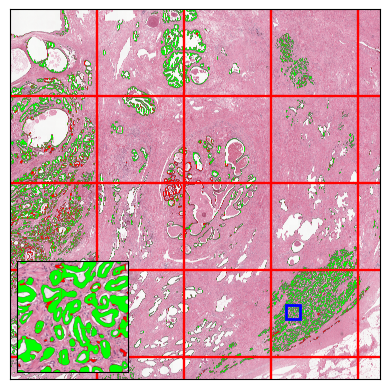

In [25]:
peso_med=np.load(save_path)
slide = np.array(slide)[:,:,:3]
my_plot(peso_med, f"peso_med{subject}", show_grid='med')

In [ ]:




# === Load experiment config ===


# === Load model weights ===
model: OctreeNCA2DPatch2 = exp.model
model.load_state_dict(torch.load(model_weights_path))  # 👈 load from .pth
model = model.eval().cuda()

# === Inference on WSI region ===
subject, pos_x, pos_y = "22", 5000, 18000
slide = openslide.open_slide(f"/local/scratch/PESO/peso_training/pds_{subject}_HE.tif")
size = (850 * 16, 850 * 16)
region = slide.read_region((int(pos_x * slide.level_downsamples[1]), int(pos_y * slide.level_downsamples[1])), 1, size)
region = np.array(region)[:, :, :3].astype(np.float32) / 255.0

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
region = (region - mean) / std
region = torch.tensor(region).permute(2, 0, 1).unsqueeze(0).float().cuda()  # (1, 3, H, W)

PATCH_SIZE = (330 * 16, 330 * 16)
_, _, H, W = region.shape
output = torch.zeros(H, W).to("cuda")
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
for h in range(0, H, PATCH_SIZE[0]):
    for w in range(0, W, PATCH_SIZE[1]):
        patch = region[:, :, h:h+PATCH_SIZE[0], w:w+PATCH_SIZE[1]]
        if patch.shape[2] < PATCH_SIZE[0] or patch.shape[3] < PATCH_SIZE[1]:
            continue

        patch.names = ('B', 'C', 'H', 'W')
        patch = einops.rearrange(patch, "B C H W -> B H W C")

        computed_res = model.compute_resolutions(patch.shape[1:3])
        seed = torch.zeros(1, *computed_res[-1], model.channel_n).to("cuda")
        temp = F.interpolate(patch.permute(0, 3, 1, 2), size=computed_res[-1]).permute(0, 2, 3, 1)
        seed[:, :, :, :model.input_channels] = temp

        # Backbone 2
        state = model.backbone_ncas[1](seed, steps=model.inference_steps[1], fire_rate=model.fire_rate)
        state = einops.rearrange(state, "B H W C -> B C H W")
        state = F.interpolate(state, size=computed_res[0], mode="nearest")
        temp = F.interpolate(patch.permute(0, 3, 1, 2), size=computed_res[0])
        state[0, :model.input_channels, :, :] = temp[0]
        state = einops.rearrange(state, "B C H W -> B H W C")

        # Backbone 1
        bb = model.backbone_ncas[0]
        state = einops.rearrange(state, "B H W C -> B C H W")
        const_inputs = state[:, :bb.input_channels].clone()
        for step in range(model.inference_steps[0]):
            delta = bb.conv(state)
            delta = torch.cat([state, delta], dim=1)
            delta = bb.fc0(delta)
            delta = bb.bn(delta)
            delta = F.relu(delta)
            delta = bb.fc1(delta)
            stochastic = (torch.rand_like(delta[:, :1]) < 0.5).float()
            delta *= stochastic
            state = torch.cat([const_inputs, state[:, bb.input_channels:] + delta], dim=1)

        state = einops.rearrange(state, "B C H W -> B H W C").cpu()
        output[h:h+PATCH_SIZE[0], w:w+PATCH_SIZE[1]] = state[0, :, :, 3]  # channel 3 = logits

# === Apply threshold and save ===
binary_mask = (output > 0).cpu().numpy().astype(np.uint8)
np.save("/local/scratch/clmn1/octree_study_new/qualitative/patchwise_inference_peso_med.npy", binary_mask)

plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Segmentation (Threshold=0)")
plt.axis("off")
plt.show()


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Load and preprocess image ===
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.Grayscale(),             # if input is 1 channel
    transforms.ToTensor(),
])

img = Image.open("gggggg.jpg")
input_tensor = transform(img).unsqueeze(0).to(device)  # Shape: (1, 1, 320, 320)

# === Inference ===
model.eval()
with torch.no_grad():
    output = model(input_tensor)  # Shape: (1, 13, 320, 320)
    print(f"Output : {output}")
    logits = output["logits"]  # Extract logits from the output dictionary
    probs = torch.sigmoid(logits)
    print(f"Prediction shape: {prediction.shape}, Prediction: {prediction}")

# === Visualize ===
pred_mask = prediction.squeeze().cpu().numpy()  # Shape: (320, 320)
plt.imshow(pred_mask, cmap='tab20')  # tab20 has 20 distinct colors
plt.title("Predicted Segmentation")
plt.axis("off")
plt.show()


Output : {'logits': tensor([[[[-4.8837],
          [-4.2487],
          [-4.0059],
          ...,
          [-3.9331],
          [-3.7953],
          [-4.1415]],

         [[-4.7731],
          [-4.6016],
          [-4.4613],
          ...,
          [-3.7356],
          [-3.9201],
          [-4.0662]],

         [[-4.8545],
          [-4.6881],
          [-4.1564],
          ...,
          [-3.8259],
          [-3.8100],
          [-3.6845]],

         ...,

         [[-8.3812],
          [-8.6076],
          [-7.6422],
          ...,
          [-5.7958],
          [-5.8794],
          [-5.1394]],

         [[-8.3701],
          [-7.6912],
          [-7.7380],
          ...,
          [-4.3521],
          [-6.2552],
          [-4.5217]],

         [[-7.9382],
          [-6.8423],
          [-6.1436],
          ...,
          [-6.3197],
          [-6.1342],
          [-5.4322]]]], device='cuda:0'), 'hidden_channels': tensor([[[[ 1.7160e+00,  5.4567e+00, -7.8366e+00,  ...,  1.6198e-01,


TypeError: argmax(): argument 'input' (position 1) must be Tensor, not dict

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study_config = {
    'experiment.name': r'peso_med_groupeq',
    'experiment.description': "OctreeNCA2DSegmentationWithGroupEq",
    'model.output_channels': 1,
}

study_config = study_config | configs.models.peso_med.peso_model_config
study_config = study_config | configs.trainers.nca.nca_trainer_config
study_config = study_config | configs.datasets.peso.peso_dataset_config
study_config = study_config | configs.tasks.segmentation.segmentation_task_config
study_config = study_config | configs.default.default_config

study_config['experiment.logging.also_eval_on_train'] = False
study_config['experiment.logging.evaluate_interval'] = study_config['trainer.n_epochs']+1
study_config['experiment.task.score'] = ["src.scores.PatchwiseDiceScore.PatchwiseDiceScore",
                                         "src.scores.PatchwiseIoUScore.PatchwiseIoUScore"]

study_config['model.backbone_class'] = "BasicNCA2D_GroupEq"

model = OctreeNCA2DPatch2(study_config).to(device)
model_path = "/local/scratch/pvc_groupEq/groupeq_results/Experiments/peso_med_groupeq_OctreeNCA2DSegmentationWithGroupEq/models/epoch_2000/model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

OctreeNCA2DPatch2(
  (backbone_ncas): ModuleList(
    (0-1): 2 x BasicNCA2D_GroupEq(
      (perceive): P4ConvZ2()
      (update_conv): P4ConvP4()
      (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
)

In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
pic_path = "/local/scratch/PESO/peso_training/pds_31_HE.tif"
# Open only the top-left 320x320 section
with tiff.TiffFile(pic_path) as tif:
    # Read just the region if possible
    full_img = tif.asarray()

# Crop manually
crop = full_img[52000:52320, 22000:22320]  # or [:320, :320, :] if 3D


# Display
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()



NameError: name 'Image' is not defined